# Week 5

In [121]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats import levene
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

## Python exercises for linear regression

In [122]:
# 1
housing = pd.read_csv("housing_new.csv",sep=",")

print(f"{housing.describe()}\n")
print(f"{housing.info()}\n")
print(f"{housing.head()}")

             PCCR        PRLZ       INDUS         NOX         AVR         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   14.210980   12.783984    0.554696    6.284634   68.574901   
std      8.601545   21.955011    7.987946    0.115877    0.702617   28.148861   
min      0.006320    3.873000    0.525000    0.385000    3.561000    2.900000   
25%      0.082045    3.873000    5.987250    0.449000    5.885500   45.025000   
50%      0.256510    3.873000   10.505000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   20.406500    0.624000    6.623500   94.075000   
max     88.976200  100.000000   35.812000    0.871000    8.780000  100.000000   

              DIS         RAD         TAX        TAX2         SUB        MEDV  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.718619    9.549407  408.237154   91.841897    0.250119   21.650525  
std      1.980458    8.707259 

In [123]:
# i)
print(f"Missing values:\n{housing.isnull().sum()}")

Missing values:
PCCR     0
PRLZ     0
INDUS    0
NOX      0
AVR      0
AGE      0
DIS      0
RAD      0
TAX      0
TAX2     0
SUB      0
MEDV     0
dtype: int64


      PCCR    AVR   AGE    DIS  TAX  MEDV
0  0.00632  6.575  65.2  4.090  296  24.0
1  0.02731  6.421  78.9  4.967  242  21.6
2  0.02729  7.185  61.1  4.967  242  34.7
3  0.03237  6.998  45.8  6.062  222  33.4
4  0.06905  7.147  54.2  6.062  222  36.2

PCCR:	min 0.0063,	max 88.9762,	avg 3.6135
AVR:	min 3.561,	max 8.78,	avg 6.2846
AGE:	min 2.9,	max 100.0,	avg 68.5749
DIS:	min 1.13,	max 9.223,	avg 3.7186
TAX:	min 187,	max 711,	avg 408.2372
MEDV:	min 4.6889,	max 48.8,	avg 21.6505


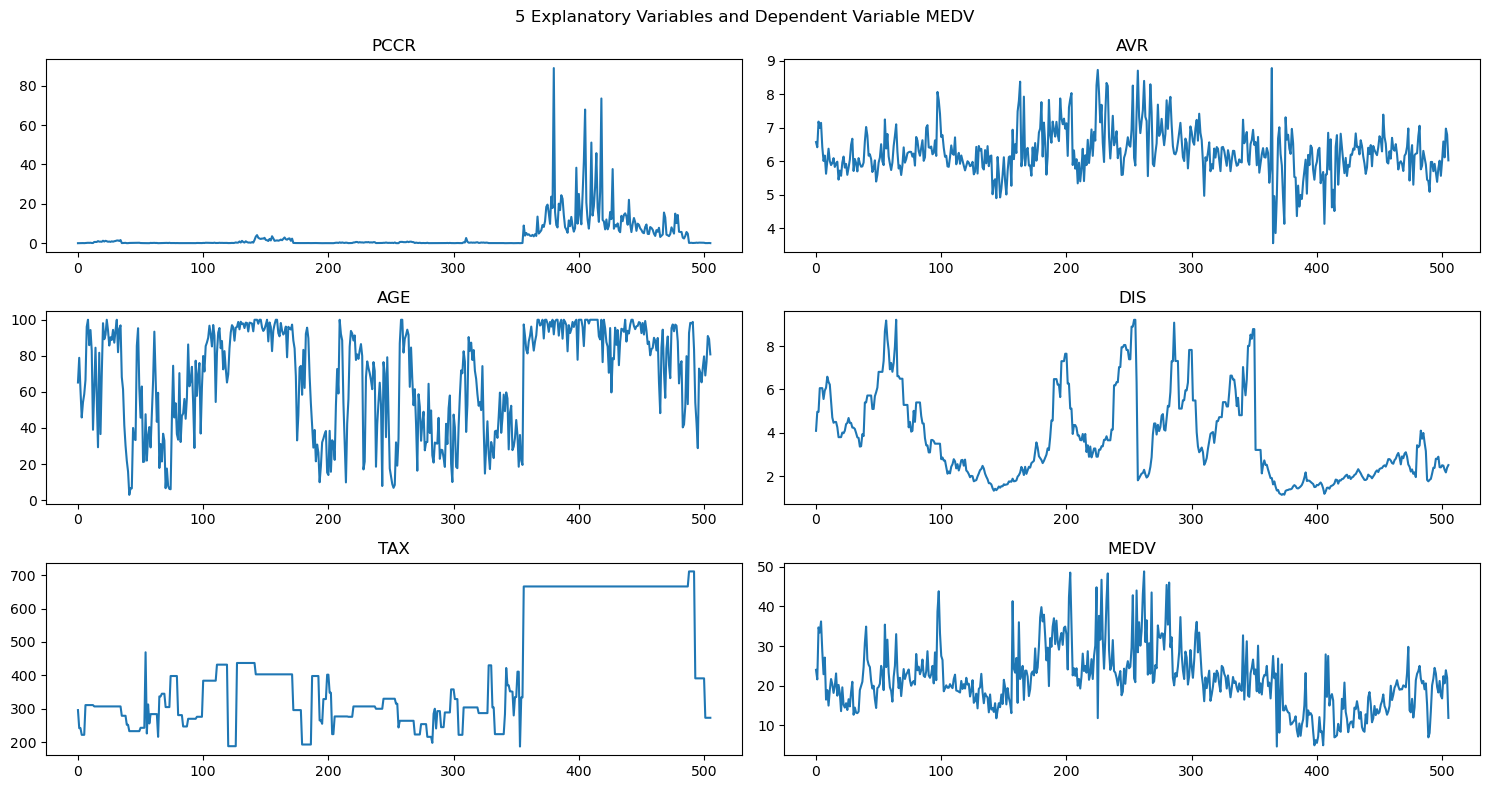

In [124]:
# ii)
# Chosen explanatory variables:
# PCCR: Per capita crime rate by town
# AVR: average number of rooms per dwelling
# AGE: ProporBon of owner-occupied units built prior to 1940
# DIS: Weighted distances to five Boston employment centers
# TAX: Full-value property tax rate per $10,000

# Dependent variable:
# MEDV: Median value of owner-occupied homes in $1000s
housing_sub = housing["PCCR AVR AGE DIS TAX MEDV".split()]

print(f"{housing_sub.head()}\n")
for col in housing_sub.columns:
    print(f"{col}:\tmin {round(housing_sub[col].min(),4)},\tmax {round(housing_sub[col].max(),4)},\tavg {round(housing_sub[col].mean(),4)}")

fig, axes = plt.subplots(3,2,figsize=(15,8))

i = 0
for row in axes:
    for ax in row:
        ax.plot(housing_sub.iloc[:,i])
        ax.set_title(str(housing_sub.columns[i]))
        i += 1

fig.suptitle("5 Explanatory Variables and Dependent Variable MEDV")
plt.tight_layout()
plt.show()

According to the information above, there's a great fluctuation between the values of each variable. Preliminary visualization shows that especially the last rows of the dataset contain observations that seem to be correlated between the explanatory variables. For example, crime rate (PCCR), age (AGE) and tax level (TAX) show parallel movement with spikes in the data. Distance to employment centers (DIS) seems to follow closely the independent variable MEDV too.

In [125]:
# iii)
corr_matrix = housing.corr()

print("Absolute correlations of X and y in descending order:")
print(abs(corr_matrix["MEDV"]).sort_values(ascending=False)[1:])

Absolute correlations of X and y in descending order:
AVR      0.638557
INDUS    0.574158
TAX      0.567976
TAX2     0.552796
NOX      0.519367
AGE      0.491994
RAD      0.475004
PCCR     0.444466
PRLZ     0.404764
DIS      0.387286
SUB      0.097151
Name: MEDV, dtype: float64


5 variables have an absolute correlation of .5 and higher with MEDV, whereas 6 have lower. Many of the absolute correlations revolve around the .5 mark, with AVR being the highest, followed by INDUS and TAX & TAX2. In other words, the number of rooms, proportion of non-retail business acres per town and tax rate seem to have a strong linear relationship with the house values.

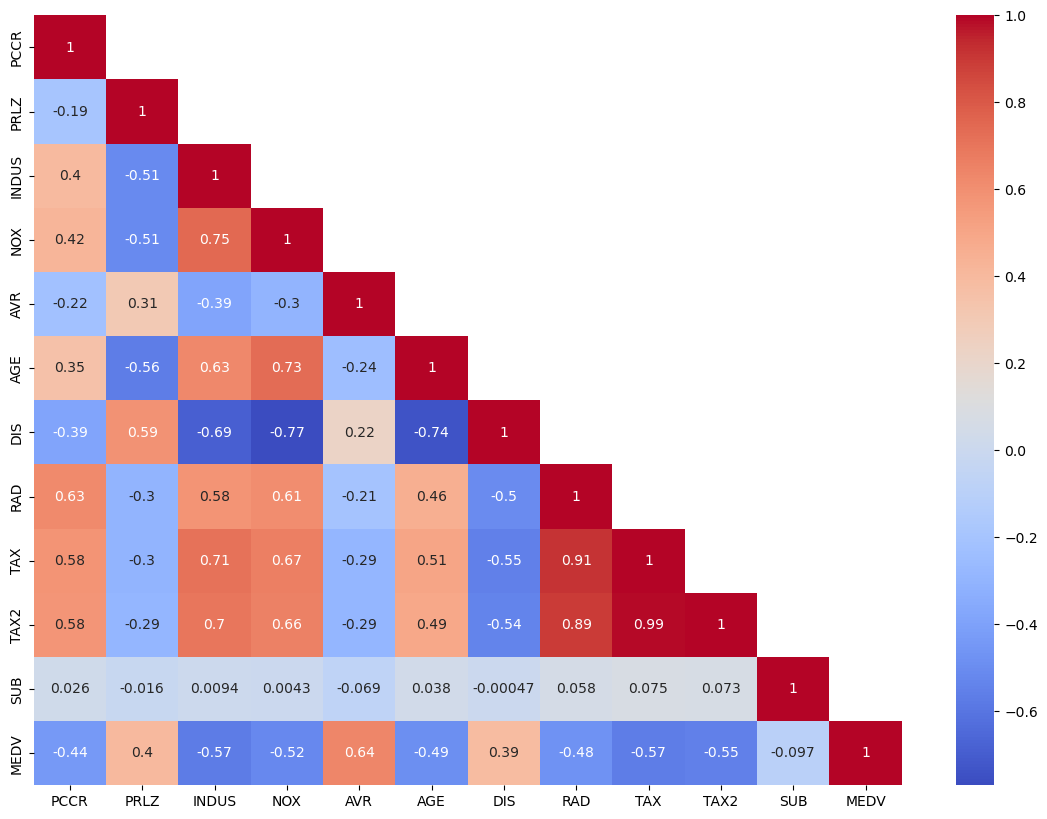

In [126]:
# iv)
mask_upper = np.triu(corr_matrix,k=1) # remove upper triangle; k=1 keep diagonal

fig2, ax2 = plt.subplots(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=mask_upper)
plt.show()

Highest correlations in absolute terms between the explanatory variables:
- TAX & RAD: 0,91
- TAX2 & RAD: 0,89
- TAX & TAX2: 0,99

Out of these three variables, removing both TAX and TAX2 allows us to retain RAD in the dataset, as it will no longer be strongly correlated with other variables. Another possibility would have been to remove one of the tax variables (TAX or TAX2) and RAD.

In [127]:
# vi) Drop TAX & TAX2
housing.drop(columns=["TAX","TAX2"],inplace=True)

# vii)
X = housing.iloc[:,:-1]
y = housing["MEDV"]

mdl = LinearRegression()
mdl.fit(X,y)

coeffs = mdl.coef_
intercept = mdl.intercept_
print(f"Intercept: {intercept}\nCoefficients: {coeffs}")

y_pred = mdl.predict(X)
residuals = y - y_pred

# viii)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y,y_pred)

print(f"\nMSE: {mse}\nRMSE: {rmse}\nR2: {r2}")

Intercept: 4.944536152413622
Coefficients: [-0.1513055   0.02607025 -0.18699826 -6.1202896   5.10921036 -0.06346759
 -0.95540766 -0.09510862 -2.51270963]

MSE: 23.69020455432393
RMSE: 4.867258422800656
R2: 0.6201011895832104


The model explains 62% of the variance in house values. The R2 score is a bit low, but still better than a simple coin toss (50-50). RMSE of 4,867 means that the predicted values are this amount away from the actual values. MEDV is in thousands of dollars, so the error is on average 4867 dollars.

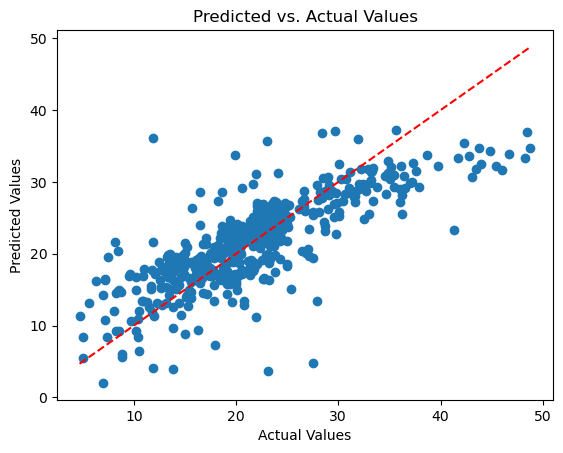

In [128]:
# ix)
fig3, ax3 = plt.subplots()
ax3.scatter(y,y_pred)
ax3.plot([y.min(),y.max()],[y.min(),y.max()],"r--")

ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.set_title("Predicted vs. Actual Values")

plt.show()

The visualization above shows that the model performs well in low values, but fails at higher values: when actual values (MEDV) are high, the predicted values tend to be too low. This sheds light on the R2 score, which was a bit too low.

1. Mean of residuals: -0.0

2. Check homoscedasticity


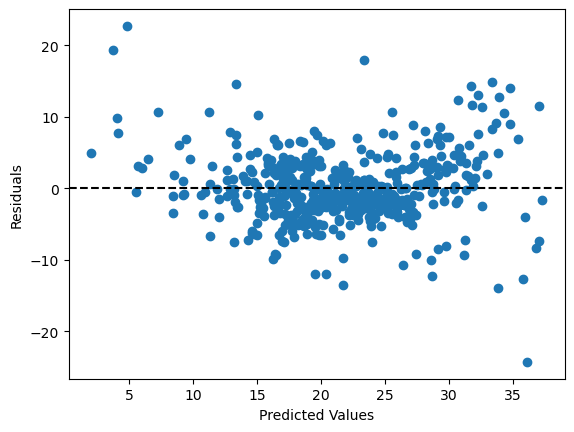

Levene statistic: 38.293600861271315
p-value: 0.0


In [129]:
# x)
# correlation was done before and highly correlated X-vars were dropped

# mean of residuals is zero:
residuals_mean = residuals.mean()
print(f"1. Mean of residuals: {round(residuals_mean,4)}")

# variance of residuals is consistent (homoscedasticity):
print("\n2. Check homoscedasticity")
fig4, ax4 = plt.subplots()
ax4.scatter(y_pred,residuals)
ax4.axhline(0,color="black",ls="--")
ax4.set_xlabel("Predicted Values")
ax4.set_ylabel("Residuals")
plt.show()

lv_stat, lv_p = levene(y_pred,residuals)
print(f"Levene statistic: {lv_stat}\np-value: {round(lv_p,4)}")

The mean of residuals is near-zero.<br><br>
The residuals seem to revolve between -20 and 20, with low prediction values being more positive, middle predictions being revolved around 0 and high prediction values scattering around 0, with more on the positive side. Based on the visualization, a slight upwards sloping parabola can be seen. The p-value from Levene is near-zero, which indicates that there's heteroschedasticity.

In [130]:
# residuals are uncorrelated (no autocorrelation):
print("3. Check for autocorrelation")
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw}")

3. Check for autocorrelation
Durbin-Watson statistic: 1.4391980868789118


The above test statistic ranges between 0 and 4, with the middle point 2 indicating no autocorrelation. A value lower than 2 indicates  positive autocorrelation and a value higher than 2 indicates negative autocorrelation. 1,4392 indicates a slight positive autocorrelation.

4. Check residual-explanatory variables correlation
PCCR     0.0
PRLZ    -0.0
INDUS    0.0
NOX      0.0
AVR     -0.0
AGE      0.0
DIS      0.0
RAD      0.0
SUB     -0.0
dtype: float64

5. Distribution of residuals


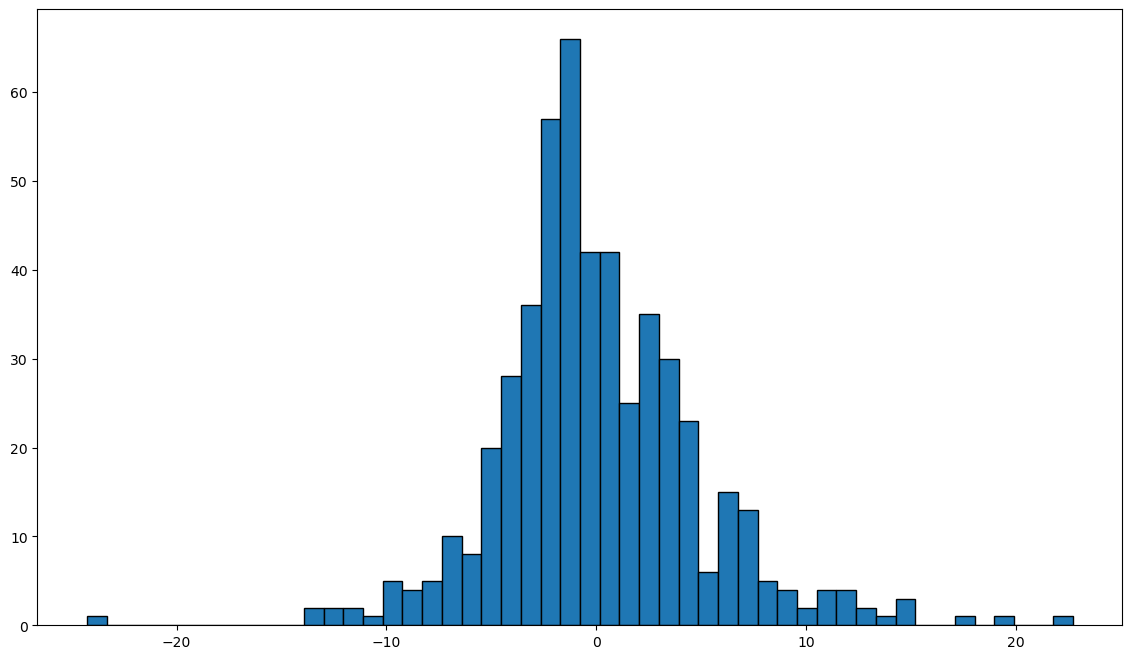

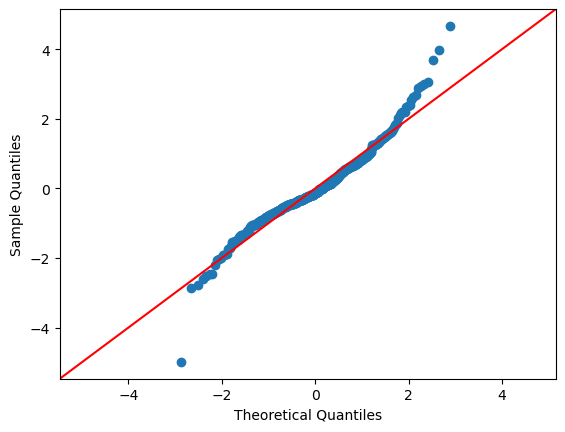

JB statistic: 194.0621625770747
p-value: 0.0


In [131]:
# residuals have no relationship with explanatory variables:
print("4. Check residual-explanatory variables correlation")
residuals_corr = X.corrwith(residuals)
print(residuals_corr.round(4))

# residuals are normally distributed:
print("\n5. Distribution of residuals")
fig5, ax5 = plt.subplots(figsize=(14,8))
ax5.hist(x=residuals,bins=50,edgecolor="black")
qqplot(residuals,line="45",fit=True)
plt.show()

jb = jarque_bera(residuals)
print(f"JB statistic: {jb[0]}\np-value: {round(jb[1],4)}")

The residual-explanatory variable correlations are near-zero and thus ok.<br><br>
With a near-zero p-value, the assumption of normality should be rejected.

In [132]:
# 2
X = sm.add_constant(X) # adds column for intercept as "const"
mdl2 = sm.OLS(y,X).fit()

# i)
print(mdl2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     89.96
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           2.31e-98
Time:                        20:58:42   Log-Likelihood:                -1518.7
No. Observations:                 506   AIC:                             3057.
Df Residuals:                     496   BIC:                             3100.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9445      3.433      1.440      0.1

In [133]:
# ii)
X_new1 = X.drop(columns=["SUB"])
mdl3 = sm.OLS(y,X_new1).fit()
print(mdl3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     100.6
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           7.60e-99
Time:                        20:58:42   Log-Likelihood:                -1520.0
No. Observations:                 506   AIC:                             3058.
Df Residuals:                     497   BIC:                             3096.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0462      3.391      1.193      0.2

In [134]:
X_new2 = X_new1.drop(columns=["NOX"])
mdl4 = sm.OLS(y,X_new2).fit()
print(mdl4.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     114.2
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           2.43e-99
Time:                        20:58:42   Log-Likelihood:                -1521.3
No. Observations:                 506   AIC:                             3059.
Df Residuals:                     498   BIC:                             3092.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9784      2.799      0.350      0.7

In [135]:
X_new3 = X_new2.drop(columns=["PRLZ"])
mdl5 = sm.OLS(y,X_new3).fit()
print(mdl5.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     131.9
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           1.27e-99
Time:                        20:58:42   Log-Likelihood:                -1523.2
No. Observations:                 506   AIC:                             3060.
Df Residuals:                     499   BIC:                             3090.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6221      2.801      0.222      0.8

The model above has only statistically significant explanatory variables, with SUB, NOX and PRLZ being dropped. The errors and t-values are also reasonable. Dropping the intercept makes no sense, even though it has a high p-value (the predicted linear equation would go through origo, i.e. start from x,y = zero in such a case, meaning a possibility for a non-existant value for a house and possibly distorting the rest of the model). <br><br>
The R2-score dropped from 62% to 61,3%, and adjusted R2 fell from 61,3 to 60,9% so the predictive ability stayed almost the same. The model is also significant (f = 131,9; p-value = 0).<br><br>
Of all the remaining coefficients, the average number of rooms per dwelling (AVR) has the most effect on the home value (y), and it is also the only positive coefficient. The rest of the X variables have a negative impact (crime, non-retail business acres, age, distance to employment centers, highway accessibility). These coefficients seem reasonable.